In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import pandas as pd

In [5]:
from lifetimes.datasets import load_dataset

cdnow_transactions = load_dataset(
    'CDNOW_sample.txt', 
    header=None, 
    delim_whitespace=True, 
    names=['customer_id', 'customer_index', 'date', 'quantity', 'amount'],
    converters={'date': lambda x: pd.to_datetime(x, format="%Y%m%d")}
)

cdnow_transactions.head()

,customer_id,customer_index,date,quantity,amount
0,4,1,1997-01-01,2,29.33
1,4,1,1997-01-18,2,29.73
2,4,1,1997-08-02,1,14.96
3,4,1,1997-12-12,2,26.48
4,21,2,1997-01-01,3,63.34


In [7]:
import lifetimes

In [8]:
# lifetimes provides a transaction log -> rfm util function
rfm = lifetimes.utils.summary_data_from_transaction_data(
    cdnow_transactions,
    'customer_id',
    'date',
    observation_period_end=pd.to_datetime('1997-09-30'),
    freq='W'
)

rfm.head()

,frequency,recency,T
customer_id,,,
4,2.0,30.0,39.0
18,0.0,0.0,39.0
21,1.0,2.0,39.0
50,0.0,0.0,39.0
60,0.0,0.0,35.0


In [11]:
from pymc3.math import exp, log

class ParetoNBD(pm.Continuous):
    """
    Custom distribution class for Pareto/NBD likelihood.
    """
    
    def __init__(self, lambda_, mu, *args, **kwargs):
        super(ParetoNBD, self).__init__(*args, **kwargs)
        self.lambda_ = lambda_
        self.mu = mu
        
    def logp(self, x, t_x, T):
        """
        Loglikelihood function for and indvidual customer's purchasing rate \lambda
        and lifetime \mu given their frequency, recency and time since first purchase.
        """
        
        log_lambda = log(self.lambda_)
        log_mu = log(self.mu)
        mu_plus_lambda = self.lambda_ + self.mu
        log_mu_plus_lambda = log(mu_plus_lambda)
        
        p_1 = x * log_lambda + log_mu - log_mu_plus_lambda - t_x * mu_plus_lambda
        p_2 = (x + 1) * log_lambda - log_mu_plus_lambda - T * mu_plus_lambda
        
        return log(exp(p_1) + exp(p_2))

In [12]:

# Extract data for model following notation from Fader/Hardie
N = rfm.shape[0] # number of customers
x = rfm['frequency'].values
t_x = rfm['recency'].values
T = rfm['T'].values # length of training period

In [19]:
n_draws = 2000

pnbd_model = pm.Model()
with pnbd_model:
    
    # Uninformative priors on model hyperparameters see Polson and Scott 
    # https://projecteuclid.org/download/pdfview_1/euclid.ba/1354024466
    r = pm.HalfCauchy('r', beta=2)
    alpha = pm.HalfCauchy('alpha', beta=2)
    s = pm.HalfCauchy('s', beta=2)
    beta = pm.HalfCauchy('beta', beta=2)
    
    # Gamma prior on purchasing rate parameter lambda
    lambda_ = pm.Gamma('lambda', alpha=r, beta=alpha, shape=N, testval=np.random.rand(N))
    # Gamma prior on lifetime parameter mu
    mu = pm.Gamma('mu', alpha=s, beta=beta, shape=N, testval=np.random.rand(N))

    # Custom distribution for Pareto-NBD likelihood function
    loglikelihood = ParetoNBD("loglikelihood", mu=mu, lambda_=lambda_, observed={'x': x, 't_x': t_x, 'T': T})
    
    # Sample the model
    trace = pm.sample(n_draws, init=None)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, beta, s, alpha, r]
Sampling 4 chains: 100%|██████████| 10000/10000 [3:07:28<00:00,  1.12s/draws] 
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


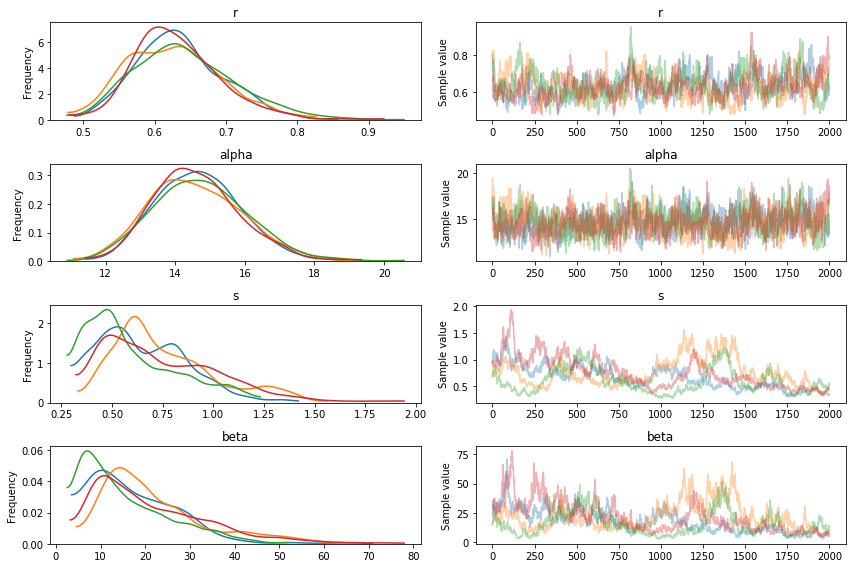

In [20]:
_ = pm.traceplot(trace, varnames=['r','alpha','s','beta'])

In [ ]:
_ = pm.plot_posterior(trace, varnames=['r','alpha','s', 'beta'])